In [1]:
!nvidia-smi

Thu Aug 31 06:16:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -U -qq gdown kaggle

from google.colab import drive
drive.mount('/content/drive')

import os
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/all_AI_code/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [3]:
import os
import json
import zipfile
import shutil
import random
import time
from pathlib import Path
from glob import glob
import cv2
import PIL
from PIL import Image, ImageOps
from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# download competition dataset
!kaggle competitions download -c hackathon-online-2022-image-processing
!mkdir /content/data/

with zipfile.ZipFile("./hackathon-online-2022-image-processing.zip", "r") as zip_ref:
    print("Unzipping main_zip data...")
    zip_ref.extractall()

with zipfile.ZipFile("./IM_Test.zipfile", "r") as zip_ref:
    zip_ref.extractall("/content/data/")

with zipfile.ZipFile("./IM_Train.zipfile", "r") as zip_ref:
    zip_ref.extractall("/content/data/")

with zipfile.ZipFile("/content/data/IM_Train.zipfile", "r") as zip_ref:
    zip_ref.extractall("/content/data/")

with zipfile.ZipFile("/content/data/IM_Test.zipfile", "r") as zip_ref:
    zip_ref.extractall("/content/data/")

!rm /content/IM_Test.zipfile /content/IM_Train.zipfile /content/hackathon-online-2022-image-processing.zip /content/data/IM_Test.zipfile /content/data/IM_Train.zipfile

100% 415M/415M [00:14<00:00, 39.6MB/s]
100% 415M/415M [00:14<00:00, 29.2MB/s]
Unzipping main_zip data...


In [5]:
ls = glob("/content/data/train/*/*.png")
df_data = pd.DataFrame(ls,columns=['path'])
df_data['label'] = df_data['path'].map(lambda x: int(x.split('/')[-2]))
df_data.tail(3)

,path,label
73254,/content/data/train/4/12929.0.png,4
73255,/content/data/train/4/19088.0.png,4
73256,/content/data/train/4/17147.0.png,4


In [6]:
# test data
!mkdir /content/data/croped_images/

with open("/content/data/IM_Test/IM_Test.json") as json_file:
    datas = json.load(json_file)

df_json = pd.json_normalize(datas)

df_test = pd.DataFrame(columns=['path', 'filename', 'imageid_boxid'])

for i in tqdm(df_json.index, desc='Croping...'):
    pth = f"/content/data/IM_Test/IM_Test/{i+1}.png"
    img = cv2.imread(pth)

    for j in df_json['bboxes'][i]:
        name = str(i+1) +'_' + str(j['bbox_id'])
        des_pth = f"/content/data/croped_images/{name}.png"
        df_test.loc[len(df_test)] = [des_pth, df_json['filename'][i], name]

        crop_img = img[j['y1']:j['y2'], j['x1']:j['x2']]
        cv2.imwrite(str(des_pth), crop_img)

Croping...: 100%|██████████| 13068/13068 [01:06<00:00, 196.64it/s]


In [7]:
# Install Timm (Need to restart the runtime after finish install )
!pip -qq install git+https://github.com/rwightman/pytorch-image-models.git
!pip -qq install lightning transformers datasets evaluate pillow==9.2.0 GPUtil

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 84.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [8]:
import GPUtil

def free_gpu_cache():
    print("Initial GPU Usage")
    GPUtil.showUtilization()
    torch.cuda.empty_cache()
    print("GPU Usage after emptying the cache")
    GPUtil.showUtilization()

In [10]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset

# Pytorch Image model (TIMM) library: a library for state-of-the-art image classification
import timm
import timm.optim
import timm.scheduler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import evaluate
from lightning.fabric import Fabric

In [11]:
# Transform image data based on ImageNet's mean and std
# mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
# std = torch.tensor([0.26862954, 0.26130258, 0.27577711])
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])
data_transforms = {
    "train": T.Compose([
        T.RandomInvert(),
        T.RandomEqualize(),
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
    ]),
    "valid": T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
    ]),
    "test": T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
    ])
}

In [12]:
class trainDataset(Dataset):
    def __init__(self, df=df_data, transforms=data_transforms, mode='train', sample=4000, fullData=False):
      self.IMG_SIZE = 224
      self.mode = mode
      if fullData:
        self.data = df_data.sample(frac=1).reset_index(drop=True)
        self.transforms = transforms[mode]
      else:
        self.data_0 = df[df['label']==0].sample(sample)
        self.data_1 = df[df['label']==1].sample(sample)
        self.data_2 = df[df['label']==2].sample(sample)
        self.data_3 = df[df['label']==3].sample(sample)
        self.data_4 = df[df['label']==4].sample(sample)
        self.data_5 = df[df['label']==5].sample(sample)
        self.data_6 = df[df['label']==6].sample(sample)
        self.data_7 = df[df['label']==7].sample(sample)
        self.data_8 = df[df['label']==8].sample(sample)
        self.data_9 = df[df['label']==9].sample(sample)
        self.data = pd.concat([self.data_0,self.data_1,self.data_2,self.data_3,self.data_4,
                               self.data_5,self.data_6,self.data_7,self.data_8,self.data_9
                               ],).sample(frac=1).reset_index(drop=True)
        self.transforms = transforms[mode]

    def __len__(self):
        return len(self.data)

    def preprocess(self, path):
      if self.mode == 'train':
        img = cv2.imread(path)
        h,w,_ = img.shape
        if w>h:
          img = img[:,int(w/2-h/2):int(w/2+h/2)]
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(image_rgb)
        img = ImageOps.contain(img, (self.IMG_SIZE, self.IMG_SIZE), Image.Resampling.LANCZOS)
        img = ImageOps.autocontrast(img)
        img = ImageOps.grayscale(img)
        img = ImageOps.autocontrast(img)
        if random.randint(0,1)==1:
          img = ImageOps.invert(img)
          img = ImageOps.pad(img, (self.IMG_SIZE, self.IMG_SIZE),method=Image.Resampling.LANCZOS, centering=(0,0))
        else:
          img = ImageOps.pad(img, (self.IMG_SIZE, self.IMG_SIZE),method=Image.Resampling.LANCZOS, centering=(0.5,0.5))
      else:
        img = Image.open(path)
        img = ImageOps.contain(img, (self.IMG_SIZE, self.IMG_SIZE), Image.Resampling.LANCZOS)
        img = ImageOps.autocontrast(img)
        img = ImageOps.grayscale(img)
        img = ImageOps.autocontrast(img)
        img = ImageOps.pad(img, (self.IMG_SIZE, self.IMG_SIZE), centering=(0, 0))
      return img.convert("RGB")

    def __getitem__(self, index):
        path = self.data['path'][index]
        label = int(path.split('/')[-2])
        img = self.preprocess(path)
        img = self.transforms(img)
        return img, label

In [13]:
train_dataset = trainDataset(df_data,transforms=data_transforms, mode='train', sample=4000, fullData=False)
print("total images :",len(train_dataset))
# plt.figure(figsize=(15, 7))
# for i in range(50):
#     img = train_dataset[i][0]
#     ax = plt.subplot(5, 10, i + 1)
#     plt.imshow(np.array(img), cmap='gray')
#     plt.title(str(train_dataset[i][1]))
#     plt.axis('off')
# plt.show()

total images : 40000


In [14]:
torch.set_float32_matmul_precision('high')
fabric = Fabric(accelerator="cuda") # , precision="16-mixed"
fabric.launch()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [16]:
timm.list_models('*maxvit*224*', pretrained=True)

['maxvit_base_tf_224.in1k',
 'maxvit_base_tf_224.in21k',
 'maxvit_large_tf_224.in1k',
 'maxvit_large_tf_224.in21k',
 'maxvit_rmlp_base_rw_224.sw_in12k',
 'maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k',
 'maxvit_rmlp_small_rw_224.sw_in1k',
 'maxvit_small_tf_224.in1k',
 'maxvit_tiny_rw_224.sw_in1k',
 'maxvit_tiny_tf_224.in1k',
 'maxvit_xlarge_tf_224.in21k']

In [13]:
# # Install torchinfo if it's not available, import it if it is
# try:
#     import torchinfo
# except:
#     !pip install torchinfo
#     import torchinfo

# from torchinfo import summary
# model_name = "tf_efficientnet_b7.ns_jft_in1k"
# model = timm.create_model(model_name, pretrained=True, num_classes=10)
# summary(model, input_size=[32, 3, 244, 244]) # do a test pass through of an example input size

In [17]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
all_eval_scores = []

# Cross Validation Configuration
metric = evaluate.load("f1")
train_batch_size = 13
eval_batch_size = 13
num_accumulate = 5
num_epochs = 10

# Load Model
model_name = "maxvit_base_tf_224.in1k"
model = timm.create_model(model_name, pretrained=True, num_classes=10)

# Load Optimizer and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=5e-4)
# optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k=6)    # update the slow weight every k steps
                                                                # update the optimizer by combine slow weight and fast weight * alpha

model, optimizer = fabric.setup(model, optimizer)

scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

info = {
        "metric_train": [],
        "metric_val": [],
        "train_loss": [],
        "val_loss": [],
        "best_metric_val": -999,
        "best_val_loss": 999,
    }
for epoch in range(num_epochs):
    train_loss_epoch = []
    val_loss_epoch = []

    train_preds = []
    train_targets = []

    val_preds = []
    val_targets = []

    if epoch==9:
      train_dataset = trainDataset(df_data,transforms = data_transforms, mode = 'train', sample = 4000, fullData = True)
    else:
      train_dataset = trainDataset(df_data,transforms = data_transforms, mode = 'train', sample = 2000, fullData = False)

    valid_dataset = trainDataset(df_data,transforms = data_transforms, mode = 'valid', sample = 400)

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_dataloader = DataLoader(valid_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=2, pin_memory=True)


    train_dataloader = fabric.setup_dataloaders(train_dataloader)
    val_dataloader = fabric.setup_dataloaders(val_dataloader)
    num_updates = epoch * len(train_dataloader)

    ### === Train Loop === ###
    ## Time
    start_time = time.monotonic()

    model.train()
    for idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch: {epoch+1} | Training ", leave=False)):
        inputs, targets = batch
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))

        fabric.backward(loss)

        # === Gradient Accumulation === #
        if ((idx + 1) % num_accumulate == 0) or (idx + 1 == len(train_dataloader)):
            optimizer.step()
            scheduler.step_update(num_updates=num_updates)
            optimizer.zero_grad()
        # ============================= #

        train_loss_epoch.append(loss.item())
        train_preds += outputs.argmax(-1).detach().cpu().tolist()
        train_targets += targets.tolist()
    ### ==================== ###

    # optimizer.sync_lookahead()              # Sync slow weight and fast weight
    scheduler.step(epoch + 1)

    ### === Evaluation Loop === ###
    if epoch%3==0 or epoch>9:
      model.eval()
      with torch.no_grad():
          for batch in tqdm(val_dataloader, desc=f"Epoch: {epoch+1} | Evaluating ", leave=False):
              inputs, targets = batch
              outputs = model(inputs.to(device))
              loss = criterion(outputs, targets.to(device))

              # Log Values
              val_loss_epoch.append(loss.item())
              val_preds += outputs.argmax(-1).detach().cpu().tolist()
              val_targets += targets.tolist()

      metric_val = metric.compute(predictions=val_preds, references=val_targets, average='macro')['f1']
      info["metric_val"].append(metric_val)
      info["val_loss"].append(np.average(val_loss_epoch))

    else:
      metric_val = 0.0
      val_loss_epoch = 0.0

    ### ======================= ###
    ## Time train finish
    end_time = time.monotonic()

    # Log Data
    metric_train = metric.compute(predictions=train_preds, references=train_targets, average='macro')['f1']
    info["metric_train"].append(metric_train)
    info["train_loss"].append(np.average(train_loss_epoch))


    if metric_val > info["best_metric_val"]:
    # if info["val_loss"][-1] < info["best_val_loss"]:
        # print("New Best Score!")
        # print("New Best Val Loss")
        info["best_metric_val"] = metric_val
        # info["best_val_loss"] = info["val_loss"][-1]
        torch.save(model, f"/content/maxvit_base_tf_224.pt")

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    str_time = f"{epoch_mins}m {epoch_secs}s"
    print(f"Epoch: {epoch+1} : {str_time.ljust(7)} | Loss : train {np.average(train_loss_epoch):.4f} valid {np.average(val_loss_epoch):.4f} | f1-macro : train {metric_train*100:.2f}% valid {metric_val*100:.2f}%")
    # print(info)
    # save all best metric val
    # all_eval_scores.append(info["best_metric_val"])

Epoch: 1 : 9m 55s  | Loss : train 0.5023 valid 0.3009 | f1-macro : train 84.63% valid 90.77%


Epoch: 2 : 9m 10s  | Loss : train 0.2752 valid 0.0000 | f1-macro : train 92.04% valid 0.00%


Epoch: 3 : 9m 12s  | Loss : train 0.2309 valid 0.0000 | f1-macro : train 93.16% valid 0.00%


Epoch: 4 : 10m 4s  | Loss : train 0.2043 valid 0.2176 | f1-macro : train 94.10% valid 93.62%


Epoch: 5 : 9m 39s  | Loss : train 0.1771 valid 0.0000 | f1-macro : train 94.93% valid 0.00%


Epoch: 6 : 9m 12s  | Loss : train 0.1513 valid 0.0000 | f1-macro : train 95.73% valid 0.00%


Epoch: 7 : 9m 52s  | Loss : train 0.1249 valid 0.1313 | f1-macro : train 96.62% valid 96.14%


Epoch: 8 : 9m 12s  | Loss : train 0.1023 valid 0.0000 | f1-macro : train 97.26% valid 0.00%


Epoch: 9 : 9m 13s  | Loss : train 0.0897 valid 0.0000 | f1-macro : train 97.66% valid 0.00%


Epoch: 10 : 36m 6s  | Loss : train 0.0836 valid 0.1464 | f1-macro : train 97.94% valid 96.08%


In [19]:
# save latest trained model at epoch 30
torch.save(model, f"/content/maxvit_base_tf_224_ep10.pt")

In [20]:
# prediction report base on balance classes at model ep30
fake_test_dataset = trainDataset(df_data,transforms = data_transforms, mode = 'test', sample = 600)
fake_test_dataloader = DataLoader(fake_test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=2, pin_memory=True)
loaded_model = torch.load(f"/content/maxvit_base_tf_224_ep10.pt")
ls_ans_fake_test = []
ls_target =[]

loaded_model.eval()
with torch.no_grad():
    for batch in tqdm(fake_test_dataloader, desc="Evaluating ", leave=False):
        inputs, targets = batch
        outputs = loaded_model(inputs.to(device))
        y_pred = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
        ls_ans_fake_test.extend(y_pred.tolist())
        ls_target.extend(targets.tolist())
print(classification_report(ls_ans_fake_test, ls_target))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       608
           1       0.96      0.92      0.94       630
           2       0.98      0.94      0.96       627
           3       0.95      0.95      0.95       600
           4       0.95      0.98      0.97       580
           5       0.94      0.98      0.96       576
           6       0.95      0.99      0.97       581
           7       0.95      0.99      0.97       580
           8       0.97      0.95      0.96       611
           9       0.97      0.96      0.97       607

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000



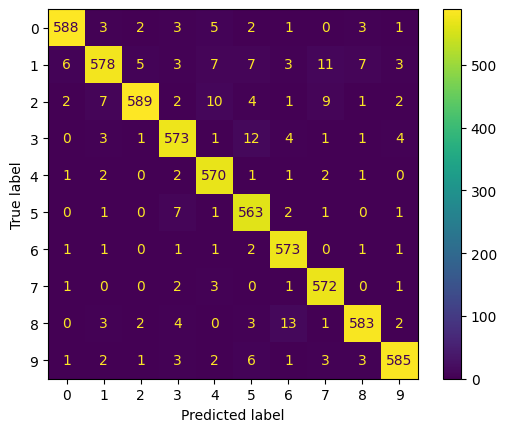

In [21]:
cm = confusion_matrix(ls_ans_fake_test, ls_target)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [22]:
# prediction report base on balance classes at model best
loaded_model = torch.load(f"/content/maxvit_base_tf_224.pt")
ls_ans_fake_test = []
ls_target =[]

loaded_model.eval()
with torch.no_grad():
    for batch in tqdm(fake_test_dataloader, desc="Evaluating ", leave=False):
        inputs, targets = batch
        outputs = loaded_model(inputs.to(device))
        y_pred = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
        ls_ans_fake_test.extend(y_pred.tolist())
        ls_target.extend(targets.tolist())
print(classification_report(ls_ans_fake_test, ls_target))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       588
           1       0.95      0.89      0.92       643
           2       0.97      0.95      0.96       611
           3       0.95      0.96      0.95       594
           4       0.94      0.98      0.96       579
           5       0.94      0.95      0.95       591
           6       0.96      0.96      0.96       598
           7       0.94      0.98      0.96       575
           8       0.97      0.91      0.94       639
           9       0.94      0.97      0.95       582

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



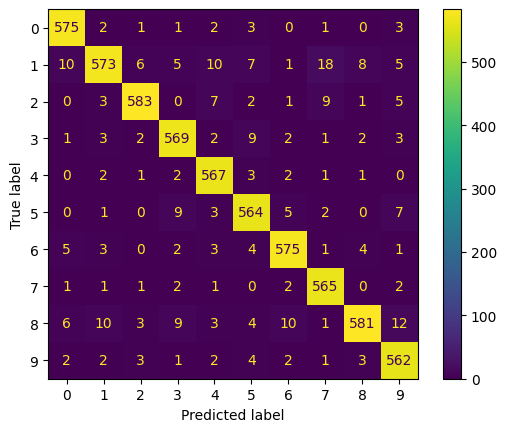

In [23]:
cm = confusion_matrix(ls_ans_fake_test, ls_target)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [24]:
class testDataset(Dataset):
    def __init__(self, df = df_data, transforms = data_transforms, mode = 'test'):
        self.data = df
        self.transforms = transforms[mode]
        self.IMG_SIZE = 224

    def __len__(self):
        return len(self.data)

    def preprocess(self, path):
        img = Image.open(path)
        img = ImageOps.contain(img, (self.IMG_SIZE, self.IMG_SIZE), Image.Resampling.LANCZOS)
        img = ImageOps.autocontrast(img)
        img = ImageOps.grayscale(img)
        img = ImageOps.autocontrast(img)
        img = ImageOps.pad(img, (self.IMG_SIZE, self.IMG_SIZE), centering=(0, 0))
        return img.convert("RGB")

    def __getitem__(self, index):
        path = self.data['path'][index]
        img = self.preprocess(path)
        img = self.transforms(img)
        return img

test_dataset = testDataset(df_test, transforms=data_transforms, mode='test')
test_dataloader = DataLoader(test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [26]:
ls_ans = []

loaded_model = torch.load(f"/content/maxvit_base_tf_224_ep10.pt")
loaded_model.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating ", leave=False):
        inputs = batch
        outputs = loaded_model(inputs.to(device))
        y_pred = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
        ls_ans.extend(y_pred.tolist())

In [27]:
ls_ans[:15]

[5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4]

In [25]:
df_test

,path,filename,imageid_boxid
0,/content/data/croped_images/1_0.png,1.png,1_0
1,/content/data/croped_images/2_0.png,2.png,2_0
2,/content/data/croped_images/2_1.png,2.png,2_1
3,/content/data/croped_images/2_2.png,2.png,2_2
4,/content/data/croped_images/3_0.png,3.png,3_0
...,...,...,...
26027,/content/data/croped_images/13067_0.png,13067.png,13067_0
26028,/content/data/croped_images/13067_1.png,13067.png,13067_1
26029,/content/data/croped_images/13067_2.png,13067.png,13067_2
26030,/content/data/croped_images/13068_0.png,13068.png,13068_0


In [29]:
df_submit = pd.read_csv('/content/IM_Submit.csv')
df_submit['class'] = ls_ans
df_submit

,imageid_boxid,class
0,1_0,5
1,2_0,2
2,2_1,1
3,2_2,0
4,3_0,6
...,...,...
26027,13067_0,2
26028,13067_1,2
26029,13067_2,7
26030,13068_0,6


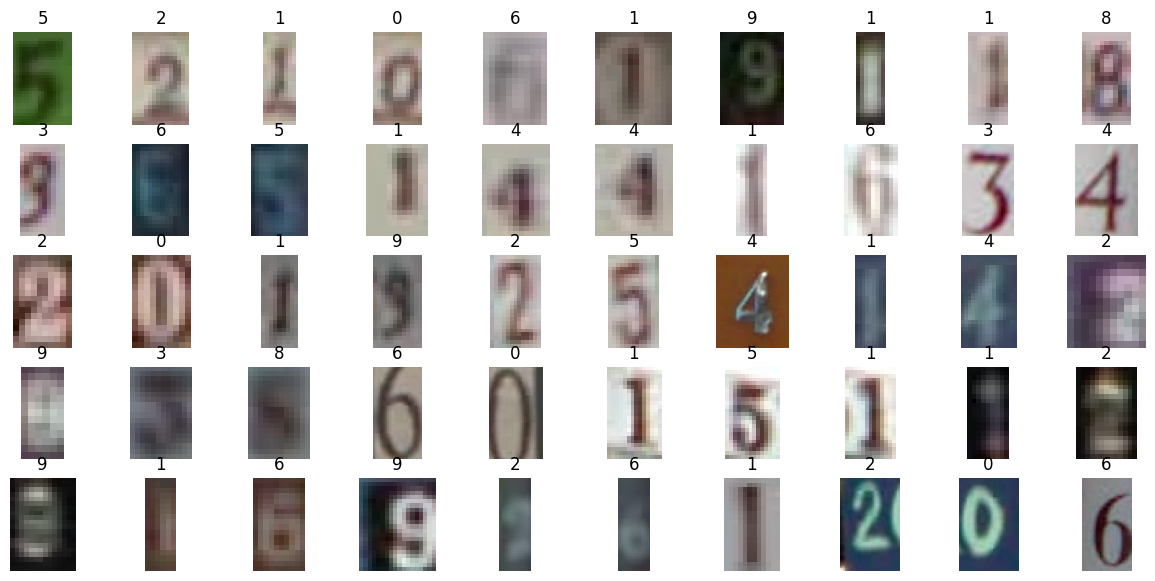

In [34]:
df = df_submit.sample(50)
ls_name = df_submit['imageid_boxid'].tolist()
ls_lable = df_submit['class'].tolist()
plt.figure(figsize=(15, 7))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
  img = cv2.imread('/content/data/croped_images/'+ls_name[i]+'.png')
  # h,w,_ = img.shape
  # if w>h:
  #   img = img[:,int(w/2-h/2):int(w/2+h/2)]
  plt.imshow(img)
  plt.title(str(ls_lable[i]))
  plt.axis('off')

In [30]:
# maxvit_base_tf_224_ep10
df_submit['class'].value_counts()

1    5059
2    4157
3    2855
4    2544
5    2353
7    2027
6    1953
0    1768
8    1674
9    1642
Name: class, dtype: int64

In [31]:
df_submit.to_csv('maxvit_base_tf_224_ep10.csv', index=False)

In [32]:
!kaggle competitions submit -c hackathon-online-2022-image-processing -f maxvit_base_tf_224_ep10.csv -m "maxvit_base_tf_224_ep10"

100% 233k/233k [00:01<00:00, 236kB/s] 
Successfully submitted to Hackathon Online: Image Processing